In [1]:
import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm
import tables
from scipy.special import ellipk, ellipe

sys.path.append(f"{os.getcwd()}/working_ViT/")
sys.path.append(f"{os.getcwd()}/mltfm/")
from VisionTransformer_working import VisionTransformer as vit_old

2022-12-19 11:09:49.342133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 11:09:49.462626: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-19 11:09:49.831040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/alexrichard/miniconda3/lib/
2022-12-19 11:09:49.831092: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.s

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


## Idea

Optimization for a linear combination of similar tasks often yields models that are more accurate, generalize better and require less training data. A possible multi-task objective for TFM could be
<h3><center>$\mathcal{L} = \alpha_{1}$$\cdot MSE + \alpha_{2}$$\cdot DTMA + \alpha_{3}$$\cdot DDA$</center></h3>
where
<h3><center>$\boldsymbol\alpha > 0, \space\space\sum_{i=1}^{3} \alpha_{i} = 1$</center></h3>


Modify data generating functions to append traction fields for every sampled traction patch.

In [14]:
def cart2pol(x, y):
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return (rho, phi)


def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)


def inCircle(X, Y, x, y, r):
    return (X - x) ** 2 + (Y - y) ** 2 <= r ** 2

In [15]:
class EventGenerator:
    def __init__(self, params):
        self.params = params
        self.displacement_mesh = self.generate_mesh(0, 1, 0, 1, params['resolutionX'])
        self.force_mesh = self.generate_mesh(0, 1, 0, 1, params['resolutionY'])
        self.E = 1000
        self.f_res = 1 / (self.params['resolutionY'] - 1)

    def generate_mesh(self, left, right, front, back, resolution):
        X, Y = np.meshgrid(np.linspace(left, right, resolution), np.linspace(front, back, resolution))
        mesh = np.array([[(X[i][j], Y[i][j]) for j in range(len(X[i]))] for i in range(len(X))])
        return mesh

    def write_PointForces(self, PointForces):
        self.data_force.append(np.array([PointForces]))
        
    def write_PointForcemeshes(self, PointForcemeshes):
        self.data_separated_forces.append(np.array([PointForcemeshes]))

    def write_Displacement(self, displacement):
        self.data_disp.append(np.array([displacement]))

    def min_dist(self, PF, point, R):
        return np.min(np.sqrt((PF.x_coord - point[0]) ** 2 + (PF.y_coord - point[1]) ** 2) - 2 * R)

    def generate_PointForces(self):
        num_i = self.params['resolutionY']
        counter = 0
        PointForcemesh = np.zeros((self.params['resolutionY'], self.params['resolutionY'], 2))
        PointForcemeshes = np.zeros((50, self.params['resolutionY'], self.params['resolutionY'], 2))
        PointForces = pd.DataFrame({"x_coord": [], "y_coord": [], "force": [], "gamma": [], "radius": []})
        while counter < np.random.uniform(10, 50):
            R = np.random.uniform(0.01, 0.05)
            point = np.random.uniform(0 + R + 0.05, 1 - R - 0.05, 2)
            force = np.random.uniform(self.params['traction_min'], self.params['traction_max'])
            force = force / self.E
            gamma = np.random.uniform(0, 2 * np.pi)
            if counter == 0 or self.min_dist(PointForces, point, R) > 0.001:
                PointForces = PointForces.append({"x_coord": point[0],
                                                  "y_coord": point[1],
                                                  "force": force,
                                                  "gamma": gamma,
                                                  "radius": R},
                                                 ignore_index=True)
                x_f, y_f = pol2cart(force, gamma)
                PointForcemesh_interim = np.zeros((self.params['resolutionY'], self.params['resolutionY'], 2))
                PointForcemesh_interim[
                    inCircle(self.force_mesh[:, :, 0], self.force_mesh[:, :, 1], point[0], point[1], R)] += np.array(
                    [x_f, y_f])
                PointForcemesh[
                    inCircle(self.force_mesh[:, :, 0], self.force_mesh[:, :, 1], point[0], point[1], R)] += np.array(
                    [x_f, y_f])
                PointForcemeshes[counter, :, :, :] = PointForcemesh_interim
                counter += 1

        return PointForcemesh, PointForcemeshes, PointForces

    def generate_displacement(self, PointForces):
        raise NotImplementedError
    
    def generate(self, event_num):
        atom = tables.Float64Atom()
        f_data_disp = tables.open_file('../ViT-TFM/data/data_with_patch_info/displacements_10.h5', mode='w')
        self.data_disp = f_data_disp.create_earray(f_data_disp.root, 'data', atom,
                                                   (0, self.params['resolutionX'], self.params['resolutionX'], 2))
        
        f_data_separated_forces = tables.open_file('../ViT-TFM/data/data_with_patch_info/separated_tractions_10.h5', mode='w')
        self.data_separated_forces = f_data_separated_forces.create_earray(f_data_separated_forces.root, 'data', atom,
                                                     (0, 50, self.params['resolutionY'], self.params['resolutionY'], 2))
        
        f_data_force = tables.open_file('../ViT-TFM/data/data_with_patch_info/tractions_10.h5', mode='w')
        self.data_force = f_data_force.create_earray(f_data_force.root, 'data', atom,
                                                     (0, self.params['resolutionY'], self.params['resolutionY'], 2))
        for i in tqdm(range(event_num)):
            PointForcemesh, PointForcemeshes, PointForces = self.generate_PointForces()
            displacement = self.generate_displacement(PointForces)
            self.write_PointForces(PointForcemesh)
            self.write_PointForcemeshes(PointForcemeshes)
            self.write_Displacement(displacement)
        f_data_disp.close()
        f_data_separated_forces.close()
        f_data_force.close()

In [16]:
class AnalyticalEventGenerator(EventGenerator):

    def analytical(self, point, traction, R):
        p0 = traction[0]
        gamma = traction[1]
        r, theta = cart2pol(point[0], point[1])
        if r < R:
            if r < 1e-4:
                N1 = 2 * np.pi
                N2 = np.pi
                N3 = 0
                N4 = np.pi
            zeta1 = r ** 2 / R ** 2
            E0 = ellipe(zeta1)
            K0 = ellipk(zeta1)
            N1 = 4 * E0
            N2 = (4 * np.cos(2 * theta) * ((r ** 2 + R ** 2) * E0 + (r ** 2 - R ** 2) * K0)) / (
                        3 * r ** 2) + 4 * np.sin(theta) ** 2 * E0
            N3 = (2 * np.sin(2 * theta) * ((r ** 2 - 2 * R ** 2) * E0 + 2 * (R ** 2 - r ** 2) * K0)) / (3 * r ** 2)
            N4 = 4 * np.cos(theta) ** 2 * E0 - (
                        4 * np.cos(2 * theta) * ((r ** 2 + R ** 2) * E0 + (r ** 2 - R ** 2) * K0)) / (3 * r ** 2)
        else:
            zeta2 = R ** 2 / r ** 2
            E0 = ellipe(zeta2)
            K0 = ellipk(zeta2)
            N1 = (4 * (r ** 2 * E0 + (R ** 2 - r ** 2) * K0)) / (r * R)
            N2 = ((6 * r ** 2 - 2 * (r ** 2 - 2 * R ** 2) * np.cos(2 * theta)) * E0 + 2 * (r ** 2 - R ** 2) * (
                        np.cos(2 * theta) - 3) * K0) / (3 * r * R)
            N3 = (2 * np.sin(2 * theta) * ((r ** 2 - 2 * R ** 2) * E0 + (R ** 2 - r ** 2) * K0)) / (3 * r * R)
            N4 = ((6 * r ** 2 + 2 * (r ** 2 - 2 * R ** 2) * np.cos(2 * theta)) * E0 - 2 * (r ** 2 - R ** 2) * (
                        np.cos(2 * theta) + 3) * K0) / (3 * r * R)
        ux = R * (1 + self.params['nu']) / (np.pi) * (
                    ((1 - self.params['nu']) * N1 + self.params['nu'] * N2) * p0 * np.cos(gamma) - self.params[
                'nu'] * N3 * p0 * np.sin(gamma))
        uy = R * (1 + self.params['nu']) / (np.pi) * (-self.params['nu'] * N3 * p0 * np.cos(gamma) + (
                    (1 - self.params['nu']) * N1 + self.params['nu'] * N4) * p0 * np.sin(gamma))
        return ux, uy
            
    def generate_displacement(self, PointForces):
        displacement = np.zeros((len(self.displacement_mesh), len(self.displacement_mesh[0]), 2))
        for index, row in PointForces.iterrows():
            trafo = np.array([-row.x_coord, -row.y_coord])
            force = np.array([row.force, row.gamma])
            displacement += np.array(
                [
                    [self.analytical(self.displacement_mesh[i][j] + trafo, force, row.radius)
                        if self.analytical(self.displacement_mesh[i][j] + trafo, force, row.radius) is not np.nan
                        else self.analytical(self.displacement_mesh[i][(j - 1) % len(self.displacement_mesh[i])] + trafo, force, row.radius)
                        for j in range(len(self.displacement_mesh[i]))
                    ]
                    for i in range(len(self.displacement_mesh))
                ])
        return displacement

In [17]:
Gen = AnalyticalEventGenerator({'resolutionX': 104,
                                'resolutionY': 104,
                                'traction_min': 0,
                                'traction_max': 500,
                                'nu': 0.49})

In [18]:
# Gen.generate(10)

  0%|                                                                                                                        | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

 20%|██████████████████████▍                                                                                         | 2/10 [00:17<01:14,  9.34s/it]/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 7/10 [00:55<00:22,  7.55s/it]/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PointForces = PointForces.append({"x_coord": point[0],
/tmp/ipykernel_2302626/2942478482.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.81s/it]


In [ ]:
binary_mask = np.where(PointForcemesh != 0, 1, 0)

<IPython.core.display.Javascript object>


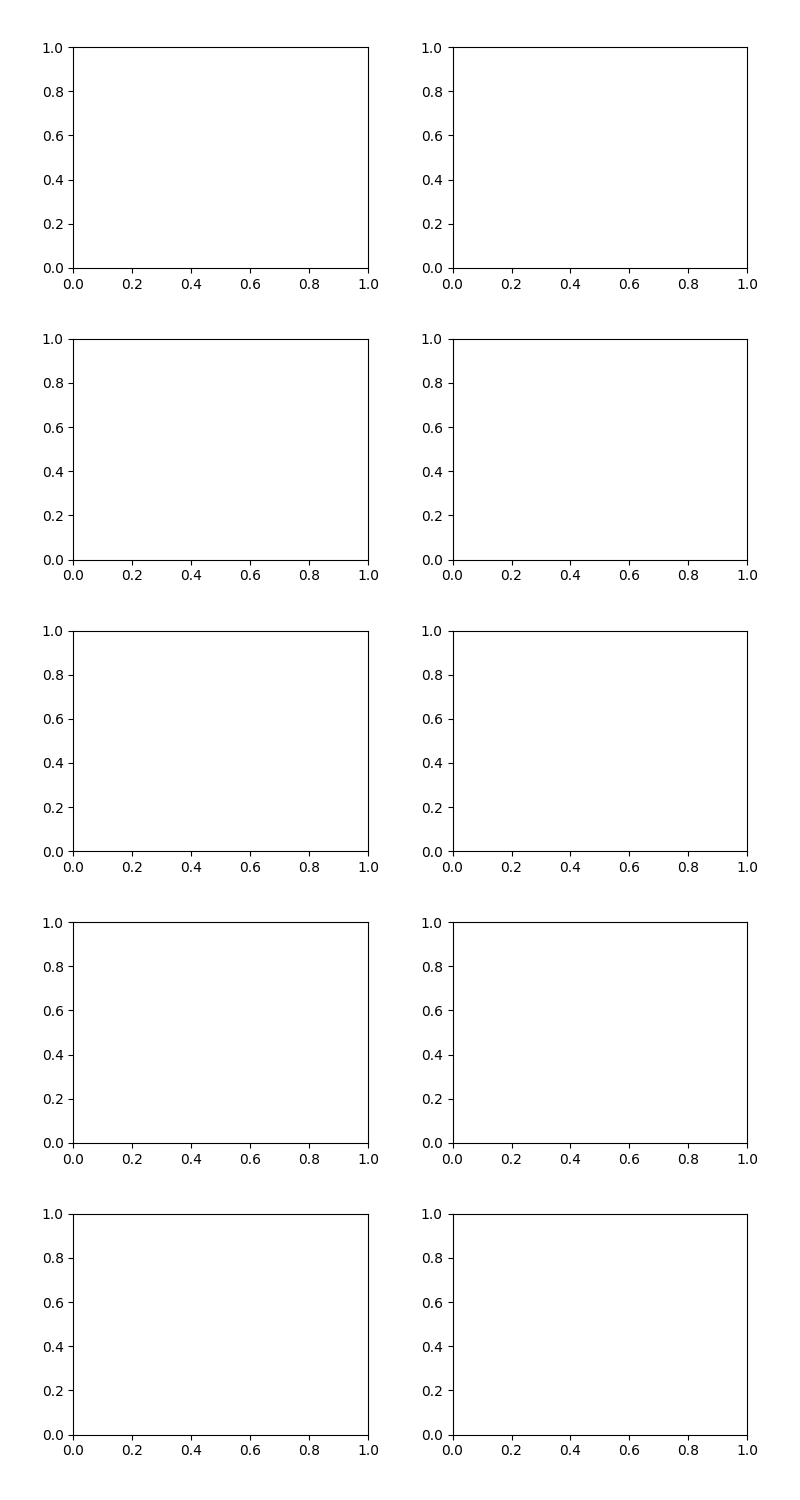

NameError: name 'PointForcemeshes' is not defined

In [86]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(5,2, figsize=(8, 15))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(PointForcemeshes[0][:,:,0], PointForcemeshes[0][:,:,1], scale=5)
axs[0, 0].set_title('PointForcemeshes[0]', {'fontsize': 11})

axs[0, 1].quiver(PointForcemeshes[1][:,:,0], PointForcemeshes[1][:,:,1], scale=5)
axs[0, 1].set_title('PointForcemeshes[1]', {'fontsize': 11})

axs[1, 0].quiver(PointForcemeshes[2][:,:,0], PointForcemeshes[2][:,:,1], scale=1)
axs[1, 0].set_title('PointForcemeshes[2]', {'fontsize': 11})

axs[1, 1].quiver(PointForcemeshes[3][:,:,0], PointForcemeshes[3][:,:,1], scale=5)
axs[1, 1].set_title('PointForcemeshes[3]', {'fontsize': 11})

axs[2, 0].quiver(PointForcemeshes[4][:,:,0], PointForcemeshes[4][:,:,1], scale=5)
axs[2, 0].set_title('PointForcemeshes[4]', {'fontsize': 11})

axs[2, 1].quiver(PointForcemeshes[5][:,:,0], PointForcemeshes[5][:,:,1], scale=5)
axs[2, 1].set_title('PointForcemeshes[5]', {'fontsize': 11})

axs[3, 0].quiver(PointForcemeshes[6][:,:,0], PointForcemeshes[6][:,:,1], scale=5)
axs[3, 0].set_title('PointForcemeshes[6]', {'fontsize': 11})

axs[3, 1].quiver(PointForcemeshes[7][:,:,0], PointForcemeshes[7][:,:,1], scale=5)
axs[3, 1].set_title('PointForcemeshes[7]', {'fontsize': 11})

axs[4, 0].quiver(PointForcemeshes[8][:,:,0], PointForcemeshes[8][:,:,1], scale=1)
axs[4, 0].set_title('PointForcemeshes[8]', {'fontsize': 11})

axs[4, 1].quiver(PointForcemesh[:,:,0], PointForcemesh[:,:,1], scale=1)
axs[4, 1].set_title('PointForcemesh', {'fontsize': 11})

In [19]:
vit_weights = vit_old(dspl_size=104,
                      patch_size=8,
                      embed_dim=128,
                      depth=12,
                      n_heads=8,
                      mlp_ratio=4.,
                      p=0.,
                      attn_p=0.,
                      drop_path=0.).double()

In [20]:
path_to_pth = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/working_ViT/logs_and_weights/ViT-2022-Dec-10 23:18:41/ViT-2022-Dec-10 23:18:41_best_val_loss_2.365828e-06.pth'

In [21]:
if torch.cuda.is_available():
    vit_weights.load_state_dict(torch.load(path_to_pth)['best_model_weights'], strict=False)
else:
    vit_weights.load_state_dict(torch.load(path_to_pth, map_location=torch.device('cpu'))['best_model_weights'], strict=False)        

In [22]:
dspl = h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/data_with_patch_info/displacements_10.h5')["data"]
trac_separated = h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/data_with_patch_info/separated_tractions_10.h5')["data"]
trac = h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/data_with_patch_info/tractions_10.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl[:, :, :, :]),3 ,1)
trac_separated_ = np.moveaxis(np.array(trac_separated[:, :, :, :]),4, 2)
trac_ = np.moveaxis(np.array(trac[:, :, : , :]),3 ,1)

X_test = torch.from_numpy(dspl_).double().to(device)
trac_separated_test = torch.from_numpy(trac_separated_).double().to(device)
Y_test = torch.from_numpy(trac_).double().to(device)

In [824]:
print(X_test.shape)
print(trac_separated_test.shape)
print(Y_test.shape)

torch.Size([10, 2, 104, 104])
torch.Size([10, 50, 2, 104, 104])
torch.Size([10, 2, 104, 104])


In [825]:
torch.equal(Y_test, torch.sum(trac_separated_test, dim=1))

True

In [23]:
vit_weights.eval()
pred_vit = vit_weights(X_test[:, :, :, :])
# pred_cnn = cnn_weights.predict(dspl[0:50, :, :, :])

In [43]:
pred_vit.shape

torch.Size([10, 2, 104, 104])

In [46]:
trac_separated_test.shape

torch.Size([10, 50, 2, 104, 104])

In [61]:
n_patches = 0
for i in range(0, 50):
    print(np.all(trac_separated_[0, i, :, :, :]==0))
    if np.all(trac_separated_[0, i, :, :, :]==0):
        n_patches += 1

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [820]:
def append_predictions(predictions, targets):
    """
    Extract predicted tractions per patch for every sample.
    
    Parameters
    __________
    predictions: torch.Tensor
        Shape `(n_samples, 2, dspl_size, dspl_size)`
        
    targets: torch.Tensor
        Shape `(n_samples, 50, 2, dspl_size, dspl_size)`
        
    Returns
    _______
    torch.Tensor
        Shape `(n_samples, 50, 2, dspl_size, dspl_size)`
    """
    n_samples, n_patches, n_channels, trac_size, _ = targets.shape
    binary_masks = torch.where(targets[:, :, :, :, :] != 0, 1, 0)
    appended_predictions = predictions.unsqueeze(1)
    appended_predictions = appended_predictions * binary_masks
    
    return appended_predictions

In [821]:
appended_predictions = append_predictions(pred_vit, trac_separated_test)

<IPython.core.display.Javascript object>


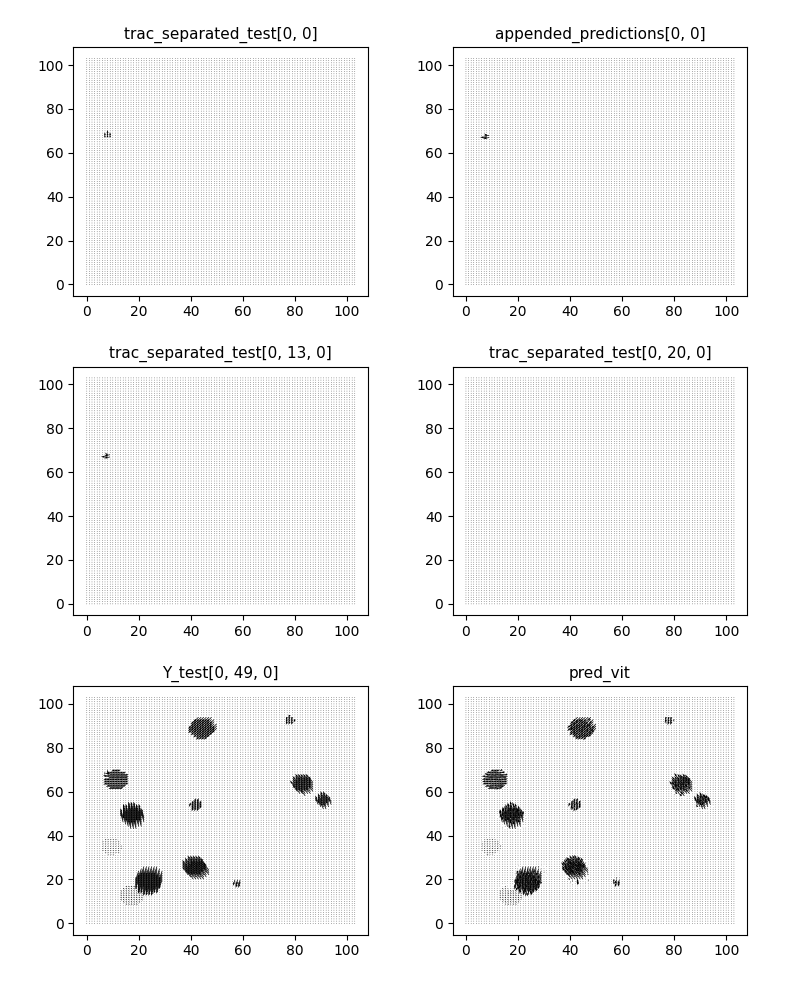

Text(0.5, 1.0, 'pred_vit')

In [815]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(3,2, figsize=(8, 10))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(trac_separated_test[0, 7, 0, :, :].detach().numpy(), trac_separated_test[0, 7, 1, :, :].detach().numpy(), scale=10)
axs[0, 0].set_title('trac_separated_test[0, 0]', {'fontsize': 11})

axs[0, 1].quiver(appended_predictions[0, 7, 0, :, :].detach().numpy(), appended_predictions[0, 7, 1, :, :].detach().numpy(), scale=10)
axs[0, 1].set_title('appended_predictions[0, 0]', {'fontsize': 11})

axs[1, 0].quiver(appended_predictions[0, 7, 0, :, :].detach().numpy(), appended_predictions[0, 7, 1, :, :].detach().numpy(), scale=10)
axs[1, 0].set_title('trac_separated_test[0, 13, 0]', {'fontsize': 11})

axs[1, 1].quiver(appended_predictions[0, 20, 0, :, :].detach().numpy(), appended_predictions[0, 20, 1, :, :].detach().numpy(), scale=10)
axs[1, 1].set_title('trac_separated_test[0, 20, 0]', {'fontsize': 11})

axs[2, 0].quiver(Y_test[0, 0, :, :].detach().numpy(), Y_test[0, 1, :, :].detach().numpy(), scale=13)
axs[2, 0].set_title('Y_test[0, 49, 0]', {'fontsize': 11})

axs[2, 1].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=13)
axs[2, 1].arrow(43, 18, Y_test[0, 0, 43, 18], 1,fc='red')
axs[2, 1].set_title('pred_vit', {'fontsize': 11})

In [568]:
def dtma(appended_predictions, targets):
    """
    Calculates the DTMA as described by Huan et al. (2019).
    
    Parameters
    __________
    appended_predictions: torch.Tensor
        Shape `(batch_size, 50, 2, dspl_size, dspl_size)`
        
    targets: torch.Tensor
        Shape `(batch_size, 50, 2, dspl_size, dspl_size)`
        
    Returns
    _______
    float
        DTMA
    """
    dspl_size = targets.shape[3]
    temp = (targets[:, :] == torch.zeros((2, dspl_size, dspl_size))).flatten(2).all((2))
    normalization = 50 - torch.sum(temp, 1)
    
    l2_pred = torch.linalg.vector_norm(appended_predictions, ord=2, dim=2)  # shape (batch_size, 50, dspl_size, dspl_size)
    l2_real = torch.linalg.vector_norm(targets, ord=2, dim=2)  # shape (batch_size, 50, dspl_size, dspl_size)
    
    l2_pred = torch.mean(l2_pred, dim=(2, 3)) # shape (batch_size, 50)
    l2_real = torch.mean(l2_real, dim=(2, 3)) # shape (batch_size, 50)
    
    nominator = (1 / normalization) * torch.sum(l2_pred - l2_real, dim=1)  # shape (batch_size)
    denominator = (1 / normalization) * torch.sum(l2_real, dim=1)  # shape (batch_size)

    dtma = torch.mean(nominator / (denominator + 1e-08))
    
    return dtma

In [569]:
dtma_ex = dtma(appended_predictions, trac_separated_test)

In [570]:
dtma_ex

tensor(-0.0355, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [550]:
trac_separated_test[:,:].shape

torch.Size([10, 50, 2, 104, 104])

In [549]:
dtma_ex

tensor([-0.0254, -0.0162, -0.0254, -0.0178, -0.0254, -0.0323, -0.0222, -0.0237,
        -0.0197, -0.0296], grad_fn=<MulBackward0>)

In [546]:
pred_vit.shape

torch.Size([10, 2, 104, 104])

In [547]:
trac_separated_test.shape

torch.Size([10, 50, 2, 104, 104])

<IPython.core.display.Javascript object>


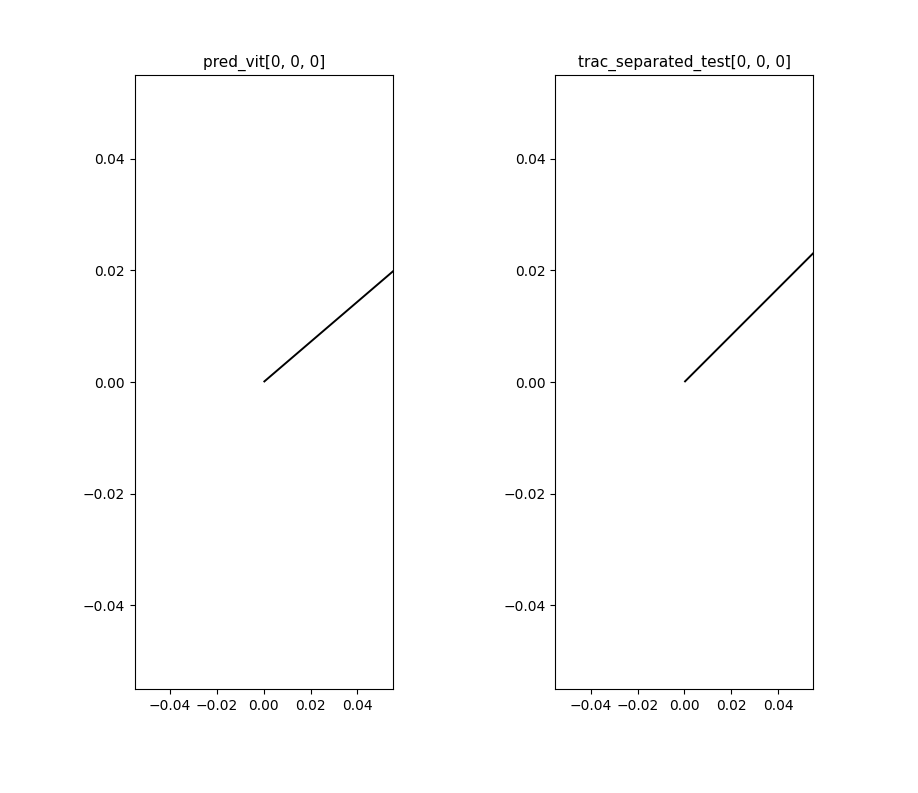

Text(0.5, 1.0, 'trac_separated_test[0, 0, 0]')

In [748]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(pred_vit[0, 0, 35, 12].detach().numpy(), pred_vit[0, 1, 35, 12].detach().numpy(), scale=0.05)
axs[0].set_title('pred_vit[0, 0, 0]', {'fontsize': 11})

axs[1].quiver(Y_test[0, 0, 35, 12].detach().numpy(), Y_test[0, 0, 35, 12].detach().numpy(), scale=0.05)
axs[1].set_title('trac_separated_test[0, 0, 0]', {'fontsize': 11})

In [816]:
def dda(appended_predictions, targets):
    """
    Calculates the DDA as described by Kierfeld et al. (2022).
    
    Parameters
    __________
    appended_predictions: torch.Tensor
        Shape `(batch_size, 50, 2, dspl_size, dspl_size)`
        
    targets: torch.Tensor
        Shape `(batch_size, 50, 2, dspl_size, dspl_size)`
        
    Returns
    _______
    float
        DDA
    """
    dspl_size = targets.shape[3]
    temp = (targets[:, :] == torch.zeros((2, dspl_size, dspl_size))).flatten(2).all((2))
    normalization = 50 - torch.sum(temp, 1)
    print(normalization)
    
    unit_vecs_preds = appended_predictions / (1e-10 + torch.linalg.vector_norm(appended_predictions, ord=2, dim=2, keepdim=True))  # shape (batch_size, 50, 2, dspl_size, dspl_size)
    unit_vecs_targets = targets / (1e-10 + torch.linalg.vector_norm(targets, ord=2, dim=2, keepdim=True))  # shape (batch_size, 50, 2, dspl_size, dspl_size)
    
    dot_prod = (unit_vecs_preds[:, :, 0, :, :] * unit_vecs_targets[:, :, 0, :, :]) + (unit_vecs_preds[:, :, 1, :, :] * unit_vecs_targets[:, :, 1, :, :])
    angles = torch.where(dot_prod != 0., torch.arccos(dot_prod), 0.)  # shape (batch_size, 50, dspl_size, dspl_size)
    norm_1 = 1 / (torch.count_nonzero(angles, dim=(2,3)) + 1e-10)  # shape (batch_size, 50)
    mean_angle_per_patch = norm_1 * torch.sum(angles, dim=(2,3))  # shape (batch_size, 50)
    
    dda = (1 / normalization) * torch.sum(mean_angle_per_patch, dim=1)
    dda = torch.mean(dda)

    return dda

In [822]:
def multi_task_loss(predictions, appended_labels):
    alpha_1 = 1/3
    alpha_2 = 1/3
    alpha_3 = 1/3
    mse = torch.nn.MSE
    appended_predictions = append_predictions(predictions)
    dtma = dtma(appended_predictions, appended_labels)
    dda = dda(appended_predictions, appended_labels)
    return alpha_1 * mse(predictions, labels) + alpha_2 * dtma + alpha_3 * dda